In [1]:
%%capture
import sklearn # import before to get new version
import os
import site
site.addsitedir('/home/schirrmr/.local/lib/python2.7/site-packages/')
site.addsitedir('/usr/lib/pymodules/python2.7/')
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/')
%cd /home/schirrmr/braindecode/code/braindecode/
assert 'THEANO_FLAGS' in os.environ
# switch to cpu
#os.environ['THEANO_FLAGS'] = 'floatX=float32,device=cpu,nvcc.fastmath=True'
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne

import matplotlib.pyplot as plt
%matplotlib inline

import gzip
import pickle

import logging
log = logging.getLogger()
log.setLevel("DEBUG")

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [3]:
train, val, test = pickle.load(gzip.open('data/mnist/mnist.pkl.gz'))

X_train, y_train = train
X_val, y_val = val

## Two digit

In [4]:
X_train_topo = X_train.reshape(X_train.shape[0], 28,28)
X_val_topo = X_val.reshape(X_val.shape[0], 28,28)

from numpy.random import RandomState

rng = RandomState(98787)
random_inds = range(len(X_train))
rng.shuffle(random_inds)

X_train_topo_both = np.concatenate([X_train_topo, X_train_topo[random_inds]], axis=2)
X_train_flat_both = X_train_topo_both.reshape(X_train_topo_both.shape[0],-1)
y_train_both = np.logical_or(y_train < 3, y_train[random_inds] < 3).astype(np.int32)
rng = RandomState(987837)
random_val_inds = range(len(X_val))
rng.shuffle(random_val_inds)
X_val_topo_both = np.concatenate([X_val_topo, X_val_topo[random_val_inds]], axis=2)
X_val_flat_both = X_val_topo_both.reshape(X_val_topo_both.shape[0],-1)
y_val_both = np.logical_or(y_val < 3, y_val[random_val_inds] < 3).astype(np.int32)

In [5]:
from braindecode.veganlasagne.layers import print_layers
three_layer_model = np.load('data/mnist/two-digit/three-conv-pool-negative-bias.pkl')

all_layers = lasagne.layers.get_all_layers(three_layer_model)
print_layers(three_layer_model)



 0 InputLayer                (None, 1568)
 1 ReshapeLayer              (None, 1, 28, 56)
 2 Conv2DLayer               (None, 3, 26, 54)
 3 Pool2DLayer               (None, 3, 13, 27)
 4 Conv2DLayer               (None, 3, 12, 26)
 5 Pool2DLayer               (None, 3, 6, 13)
 6 Conv2DLayer               (None, 3, 4, 12)
 7 Pool2DLayer               (None, 3, 2, 6)
 8 DenseLayer                (None, 2)


## Compute all activations

In [6]:
inputs = T.fmatrix()
outputs = lasagne.layers.get_output(all_layers, inputs=inputs)
all_out_fn = theano.function([inputs], outputs)
all_outs_per_layer = all_out_fn(X_train_flat_both)

## Compute all patterns

In [10]:
from braindecode.analysis.patterns import (compute_topo_covariances, transform_to_patterns,
                                           compute_patterns_for_layers, compute_patterns_for_model,
                                          pattern_deconv)

In [13]:
patterns_per_layer = compute_patterns_for_model(three_layer_model, X_train_flat_both)

INFO:braindecode.analysis.patterns:Compiling forward pass...
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 0: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 1: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.
INFO:braindecode.analysis.patterns:Transforming to patterns for layer 2: Conv2DLayer...
INFO:braindecode.analysis.patterns:Done.


## Test reconstruction from different levels

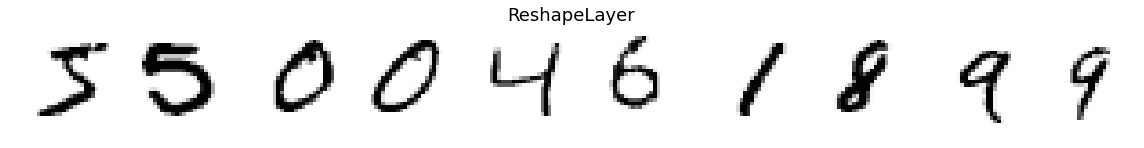

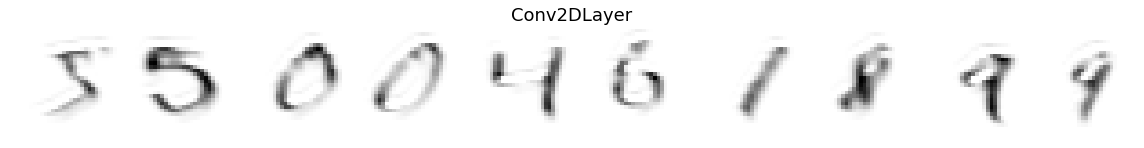

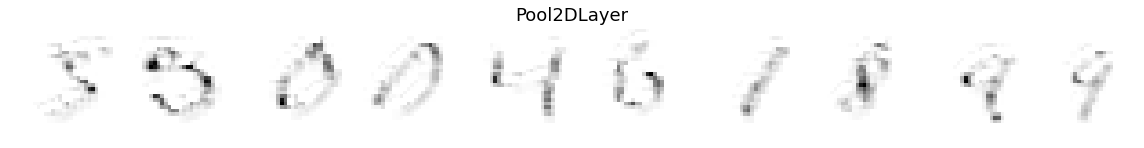

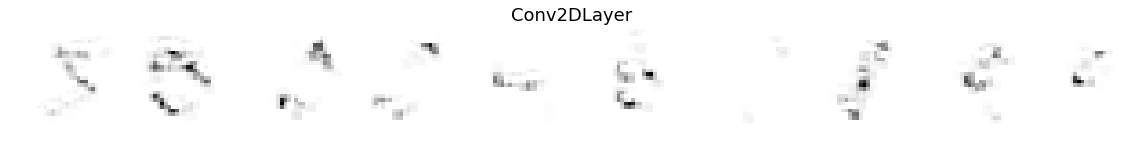

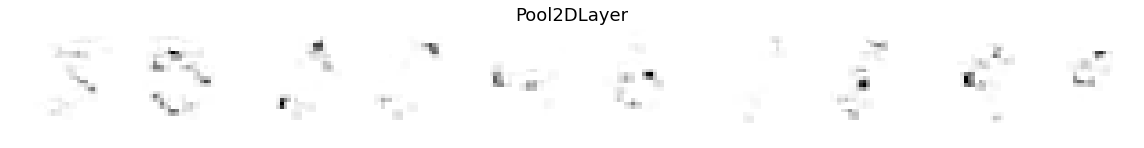

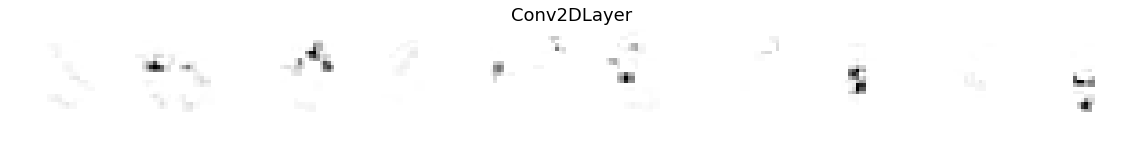

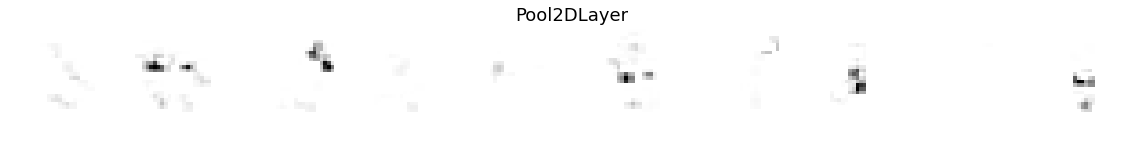

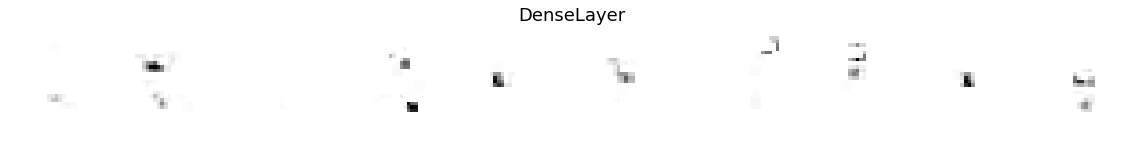

In [14]:
from matplotlib import cm
trial_inds = range(5)
for i_layer in xrange(1,len(all_layers)):
    inputs = T.fmatrix()
    if len(all_layers[i_layer].output_shape) > 2:
        outputs = T.ftensor4()
    else:
        outputs = T.fmatrix()
    this_layers = all_layers[1:i_layer+1]
    n_patterns = len([l for l in this_layers if hasattr(l, 'W')])
    deconved_var = pattern_deconv(outputs, inputs, this_layers, patterns_per_layer[:n_patterns],
                             enforce_positivity_everywhere=True)
    if i_layer > 1:
        pattern_deconv_fn = theano.function([outputs, inputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds], 
                                     X_train_flat_both[trial_inds])
    else:
        pattern_deconv_fn = theano.function([outputs], deconved_var)
        deconved = pattern_deconv_fn(all_outs_per_layer[i_layer][trial_inds])
    fig = plt.figure(figsize=(16,2))
    for i_example in xrange(len(deconved)):
        plt.subplot(1, len(deconved), i_example+1)
        plt.imshow(deconved[i_example].squeeze(), interpolation='nearest', cmap=cm.Greys)
        plt.axis('off')
    fig.suptitle(all_layers[i_layer].__class__.__name__, fontsize=18)
    plt.axis('off')
    plt.tight_layout()